# BIAS CORRECTION OF DECADAL PREDICTIONS: Demonstration of simple application

## Tools for accessing and processing climate data: Case study with R

### Herramientas para el acceso y procesamiento de datos climáticos: Caso práctico con R




------------

This worked example contains the code that reproduces part of the examples shown in the paper ["climate4R: An R-based Framework for Climate Data Access, Post-processing and Bias Correction"](https://www.sciencedirect.com/science/article/pii/S1364815218303049).

In [ ]:
library(loadeR)
library(transformeR)
library(visualizeR)
library(downscaleR)
library(magrittr)
library(geoprocessoR)
library(sp)

## Domains for the demonstrators

### Barcelona
  latLim = c(39, 44)\
  lonLim = c(-1, 4)
### Bergen
  latLim = c(58, 63)\
  lonLim = c(4, 9)
### Paris
  latLim = c(46.5, 51.5)\
  lonLim = c(-.5, 4.5)
### Prague
  latLim = c(47.5, 52.5)\
  lonLim = c(12, 17)

## 1. Data loading and basic visualization

In [4]:
ncml.dir <- "../data/ncml/EC-Earth3/dcppA-hindcast/"
datasets <- list.files(ncml.dir, full.names = T) 
datasets %>% head

[1] "../data/ncml/EC-Earth3/dcppA-hindcast//s1960-r1i4p1f1_day_tas_gr_v20220322.ncml"
[2] "../data/ncml/EC-Earth3/dcppA-hindcast//s1961-r1i4p1f1_day_tas_gr_v20220322.ncml"
[3] "../data/ncml/EC-Earth3/dcppA-hindcast//s1962-r1i4p1f1_day_tas_gr_v20220322.ncml"
[4] "../data/ncml/EC-Earth3/dcppA-hindcast//s1963-r1i4p1f1_day_tas_gr_v20220322.ncml"
[5] "../data/ncml/EC-Earth3/dcppA-hindcast//s1964-r1i4p1f1_day_tas_gr_v20220322.ncml"
[6] "../data/ncml/EC-Earth3/dcppA-hindcast//s1965-r1i4p1f1_day_tas_gr_v20220322.ncml"

In [13]:
ncml.dir.obs <- "../data/ncml/CERRA/"
dataset.obs <- list.files(ncml.dir.obs, full.names = T) 
dataset.obs

[1] "../data/ncml/CERRA//tas_f3h-r2631x1113.ncml"

### 1.1. Data loading of decadal predictions

Example for the 1984 initialization, covering Nov-1984 to Oct-1995.

In [5]:
dataset.init.1984 <- datasets %>% grep(pattern = "1984", value = T)

In [6]:
p.paris.1984.1995 <- loadGridData(dataset.init.1984, 
                        var = "tas",  
                        latLim = c(46.5, 51.5),
                        lonLim = c(0, 4.5))

[2024-04-30 08:19:32] Defining geo-location parameters

[2024-04-30 08:19:32] Defining time selection parameters

[2024-04-30 08:19:32] Retrieving data subset ...

[2024-04-30 08:19:55] Done



Structure of the obtained object 

In [7]:
str(p.paris.1984.1995)

List of 4
 $ Variable:List of 2
  ..$ varName: chr "tas"
  ..$ level  : NULL
  ..- attr(*, "use_dictionary")= logi FALSE
  ..- attr(*, "description")= chr "Near-Surface Air Temperature"
  ..- attr(*, "units")= chr "K"
  ..- attr(*, "longname")= chr "tas"
  ..- attr(*, "daily_agg_cellfun")= chr "none"
  ..- attr(*, "monthly_agg_cellfun")= chr "none"
  ..- attr(*, "verification_time")= chr "none"
 $ Data    : num [1:4017, 1:8, 1:7] 288 287 282 282 284 ...
  ..- attr(*, "dimensions")= chr [1:3] "time" "lat" "lon"
 $ xyCoords:List of 2
  ..$ x: num [1:7] 0 0.703 1.406 2.109 2.812 ...
  ..$ y: num [1:8] 46.7 47.4 48.1 48.8 49.5 ...
  ..- attr(*, "projection")= chr "LatLonProjection"
  ..- attr(*, "resX")= num 0.703
  ..- attr(*, "resY")= num 0.702
 $ Dates   :List of 2
  ..$ start: chr [1:4017] "1984-11-01 12:00:00 GMT" "1984-11-02 12:00:00 GMT" "1984-11-03 12:00:00 GMT" "1984-11-04 12:00:00 GMT" ...
  ..$ end  : chr [1:4017] "1984-11-01 12:00:00 GMT" "1984-11-02 12:00:00 GMT" "1984-11-03 1

### 1.2. Basic Data Visualization

In [8]:
library(repr)
# Change plot size 
options(repr.plot.width=10, repr.plot.height=4)

#### Temporal series for the spatial mean

pad applied on the interval: day



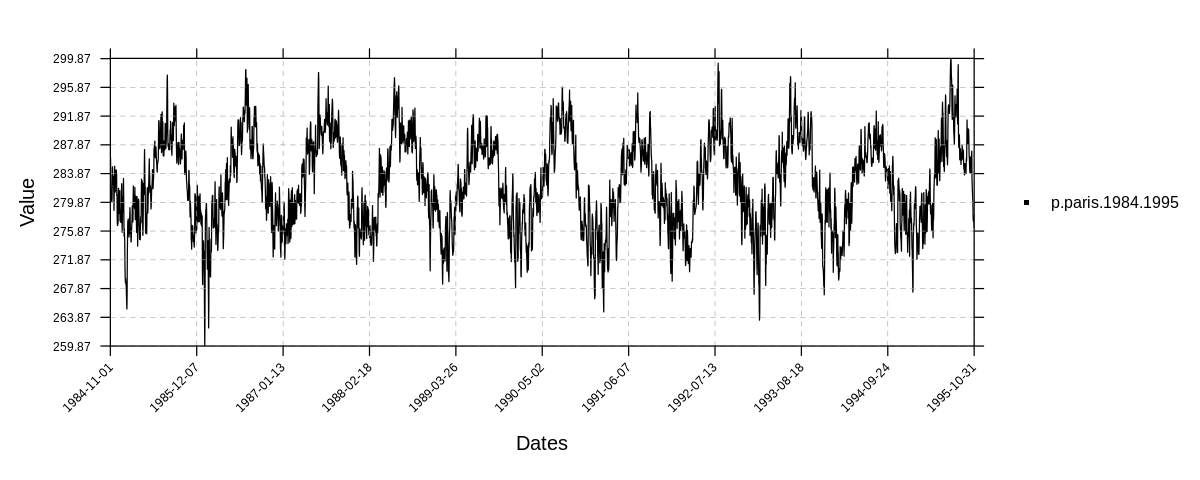

In [9]:
temporalPlot(p.paris.1984.1995)

#### Spatial map for the climatological mean

Set the coordinates for the central point representing Paris

In [10]:
paris.centre <- data.frame(x = 2.3, y = 48.8)
coordinates(paris.centre) <- ~ x + y

Map representation including the point correspondig to Paris location

[2024-04-30 08:20:14] - Computing climatology...

[2024-04-30 08:20:14] - Done.



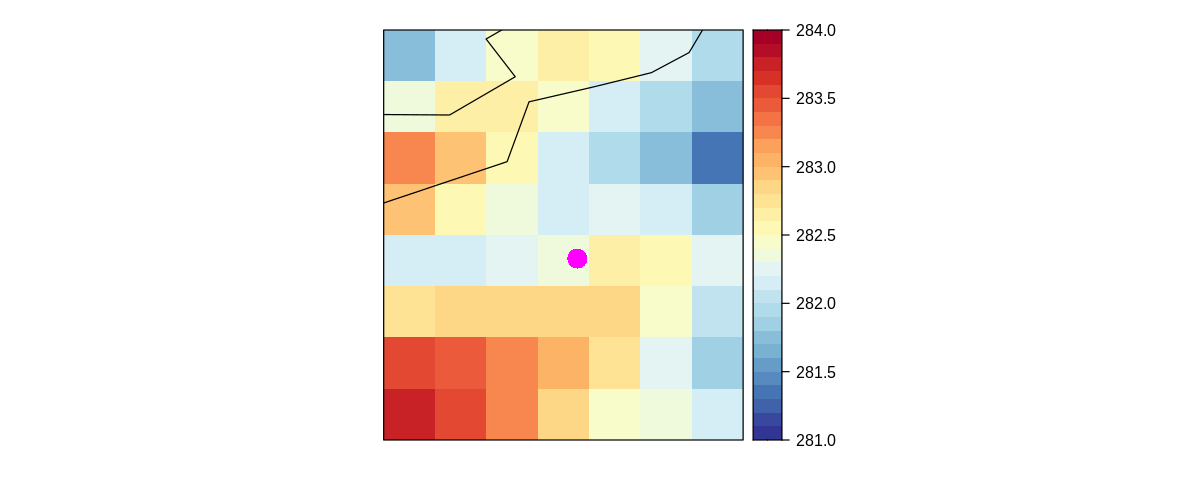

In [11]:
spatialPlot(p.paris.1984.1995 %>% climatology, 
            backdrop.theme = "coastline",
            rev.colors = TRUE,
            at = seq(281, 284, 0.1),
            sp.layout = list("sp.points", paris.centre, pch = 16, cex = 2, col = "magenta") %>% list)

### 1.3. Data loading for the observational reference

Data loading is performed in three steps to complete the series starting in November 1984 and ending in October 1995.

First the last two months of 1984 are loaded:

In [14]:
o.paris.1984 <- loadGridData(dataset.obs, 
                        var = "tas", 
                        latLim = c(46.5, 51.5),
                        lonLim = c(0, 4.5), 
                        years = 1984,
                        season = 11:12) 

[2024-04-30 08:22:09] Defining geo-location parameters

[2024-04-30 08:22:09] Defining time selection parameters

[2024-04-30 08:22:10] Retrieving data subset ...

[2024-04-30 08:22:15] Done



A first map view of the loaded grid (i.e. mean of Nov and Dec of 1984):

[2024-04-30 08:22:15] - Computing climatology...

[2024-04-30 08:22:16] - Done.



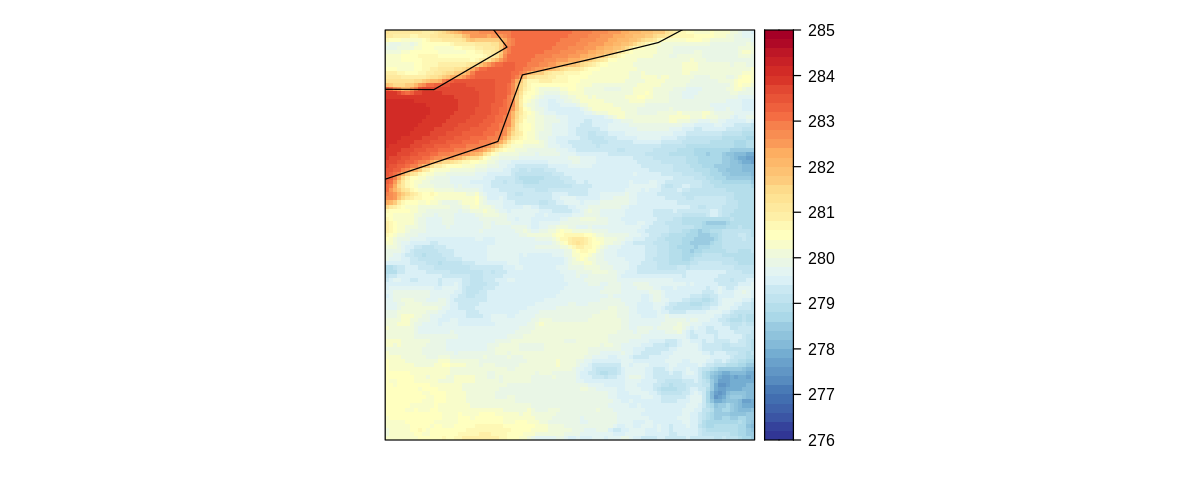

In [15]:
spatialPlot(climatology(o.paris.1984), backdrop.theme = "coastline", at = seq(276, 285, 0.2), rev.colors = TRUE)

***--> Note that the colorbar range is wider in this case.***

#### Upscale the observational reference (4 times in this example):

In [16]:
o.paris.1984.u <- upscaleGrid(o.paris.1984, times = 4, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
redim(drop = TRUE) 

[2024-04-30 08:22:17] - Computing climatology...

[2024-04-30 08:22:17] - Done.



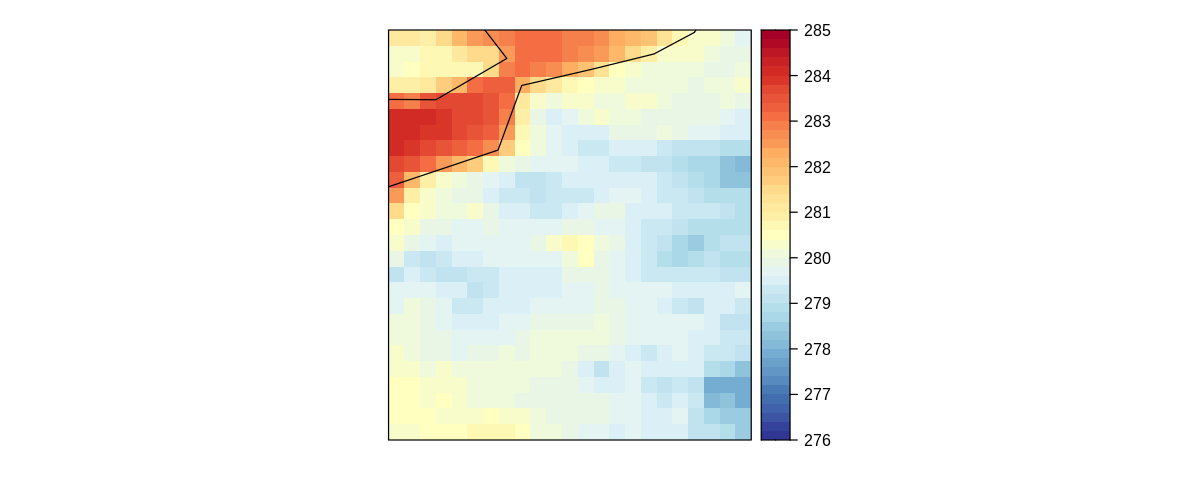

In [17]:
spatialPlot(climatology(o.paris.1984.u), backdrop.theme = "coastline", at = seq(276, 285, 0.2), rev.colors = TRUE)

#### Repeat the loading and upscaling steps for the period 1985-1994 in a loop to avoid memory overload:
(It will take a few minutes)

In [18]:
o.paris.1985.1994.u <- lapply(1985:1994, function(x) {
    loadGridData(dataset.obs, 
                 var = "tas", 
                 latLim = c(46.5, 51.5),
                 lonLim = c(0, 4.5), 
                 years = x) %>% 
    upscaleGrid(times = 4, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
    redim(drop = TRUE) %>%
    suppressMessages
}) 

#### Bind all years in the same grid:

In [19]:
o.paris.1985.1994.u.b <- do.call("bindGrid", c(o.paris.1985.1994.u, dimension = "time"))

#### Repeat the loading and upscaling steps for the first 10 months of 1995:

In [20]:
o.paris.1995.u <- loadGridData(dataset.obs, 
                        var = "tas", 
                        latLim = c(46.5, 51.5),
                        lonLim = c(0, 4.5), 
                        years = 1995,
                        season = 1:10) %>% 
    upscaleGrid(times = 4, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
    redim(drop = TRUE) %>%
    suppressMessages

#### Bind 1984, 1985-1994 and 1995:

In [21]:
o.paris.1984.1995 <- bindGrid(o.paris.1984.u, o.paris.1985.1994.u.b, o.paris.1995.u, dimension = "time")

#### Map visualization of the observational reference and the prediction:

[2024-04-30 08:29:02] - Computing climatology...

[2024-04-30 08:29:02] - Done.

[2024-04-30 08:29:03] - Computing climatology...

[2024-04-30 08:29:03] - Done.



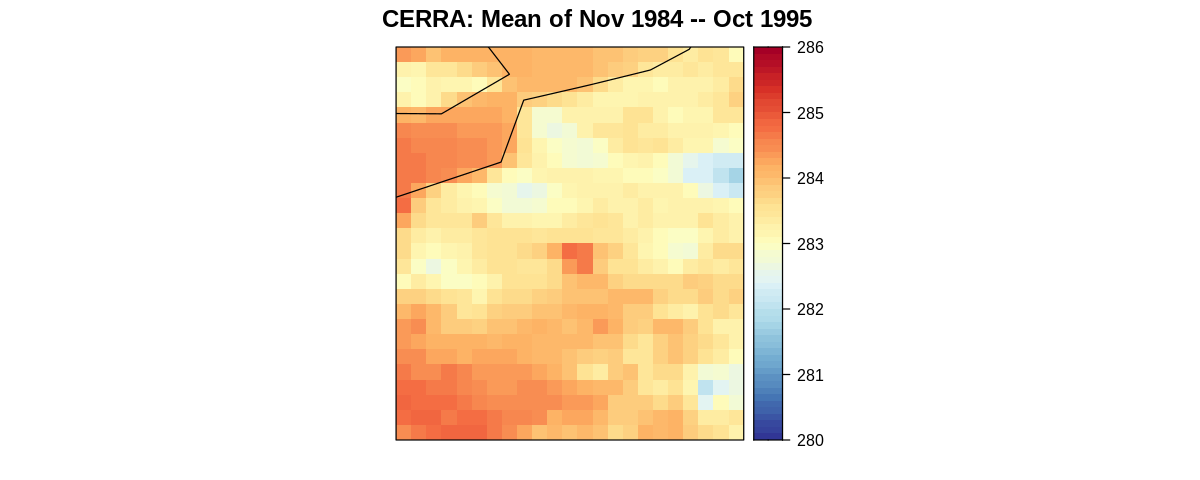

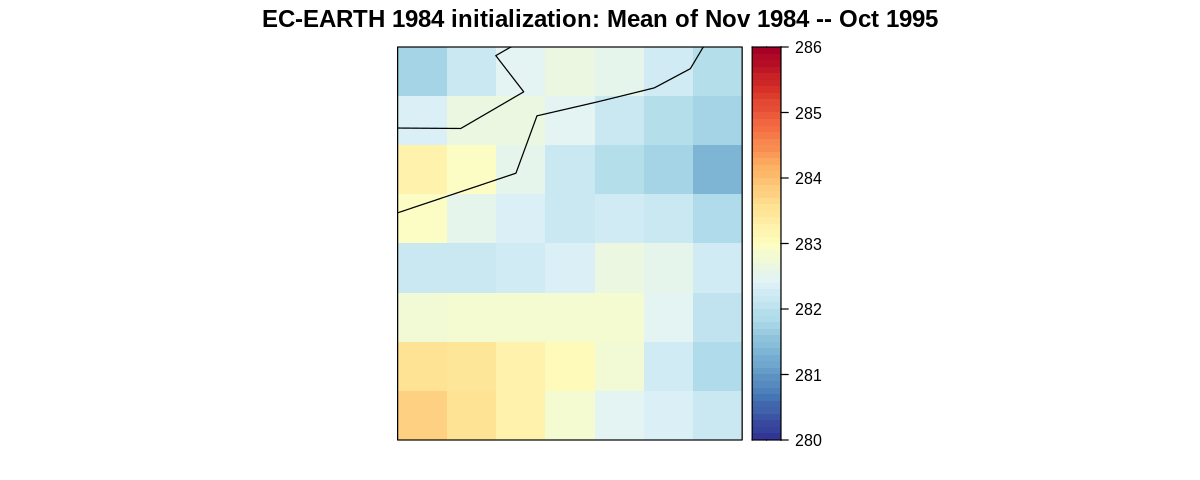

In [22]:
spatialPlot(climatology(o.paris.1984.1995), backdrop.theme = "coastline", at = seq(280, 286, 0.1), 
            rev.colors = TRUE,
            main = "CERRA: Mean of Nov 1984 -- Oct 1995 ")
spatialPlot(climatology(p.paris.1984.1995), backdrop.theme = "coastline", at = seq(280, 286, 0.1), 
            rev.colors = TRUE,
            main = "EC-EARTH 1984 initialization: Mean of Nov 1984 -- Oct 1995")

### 1.4. Visualization of the biases (observation vs prediction)

Decadal bias:

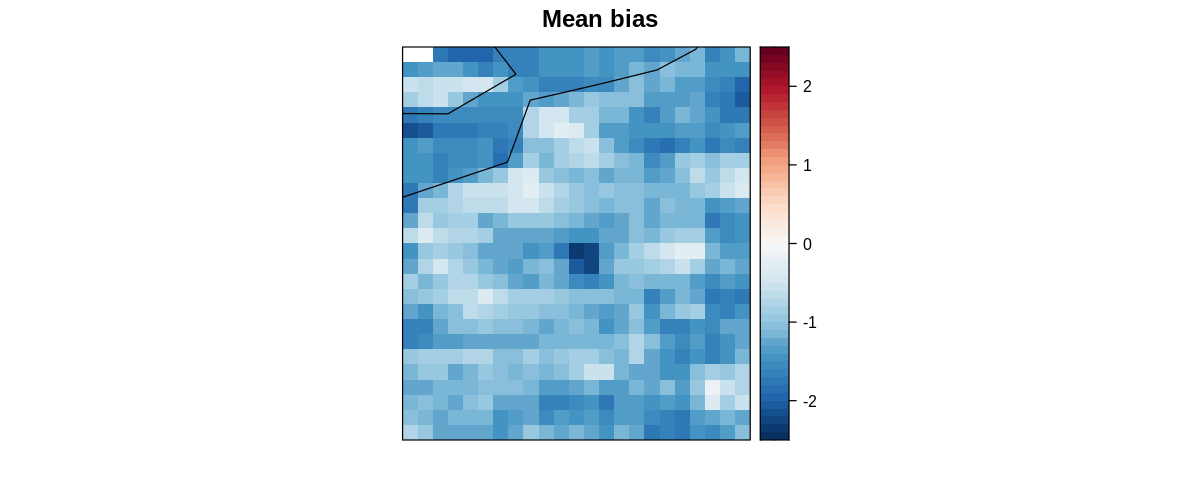

In [23]:
p.paris.1984.1995.i <- interpGrid(p.paris.1984.1995, new.coordinates = getGrid(o.paris.1984.1995)) %>% suppressMessages
diff <- gridArithmetics(p.paris.1984.1995.i %>% climatology, 
                        o.paris.1984.1995 %>% climatology, 
                        operator = "-") %>% suppressMessages
spatialPlot(diff, backdrop.theme = "coastline", at = seq(-2.5, 2.5, 0.1), 
            color.theme = "RdBu",
            rev.colors = TRUE,
            main = "Mean bias")

Daily series:

pad applied on the interval: day

pad applied on the interval: day



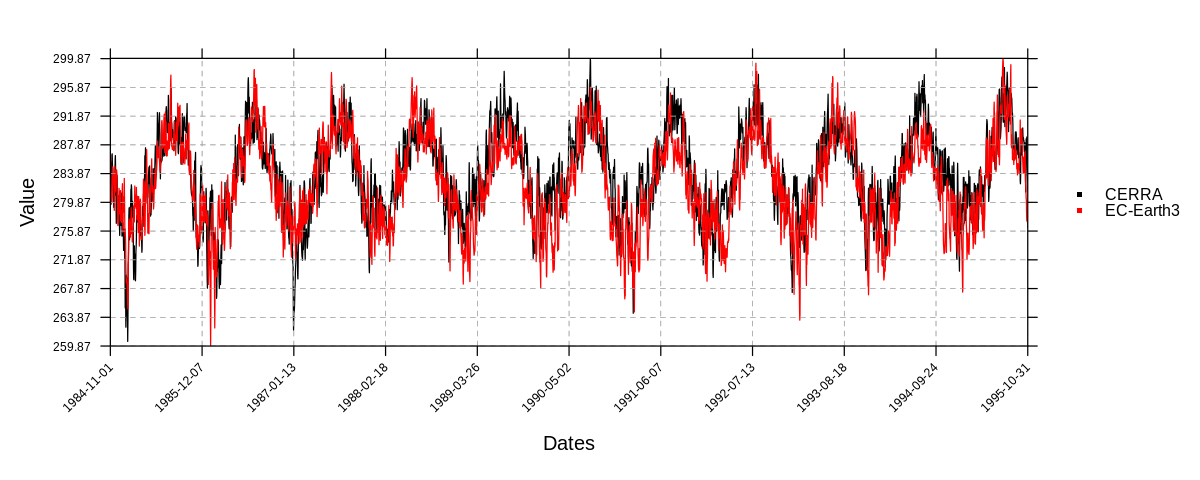

In [24]:
temporalPlot("CERRA" = o.paris.1984.1995, "EC-Earth3" = p.paris.1984.1995)

Monthly mean series:

[2024-04-30 08:29:04] Performing monthly aggregation...

[2024-04-30 08:29:05] Done.

[2024-04-30 08:29:05] Performing monthly aggregation...

[2024-04-30 08:29:05] Done.

pad applied on the interval: month

pad applied on the interval: month



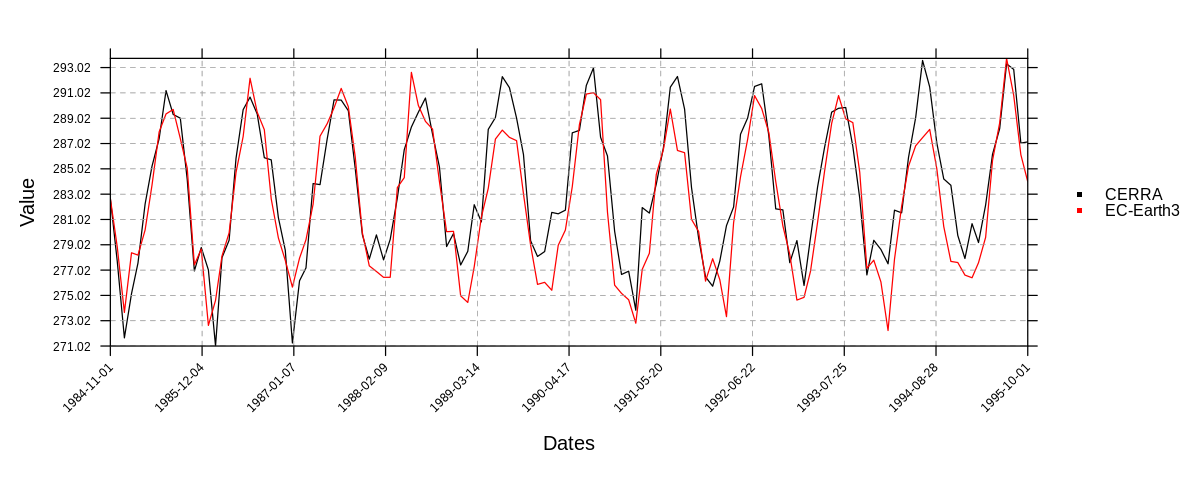

In [25]:
temporalPlot("CERRA" = o.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")))

Annual mean series:

[2024-04-30 08:29:05] Performing annual aggregation...

[2024-04-30 08:29:06] Done.

[2024-04-30 08:29:06] Performing annual aggregation...

[2024-04-30 08:29:06] Done.

pad applied on the interval: year

pad applied on the interval: year



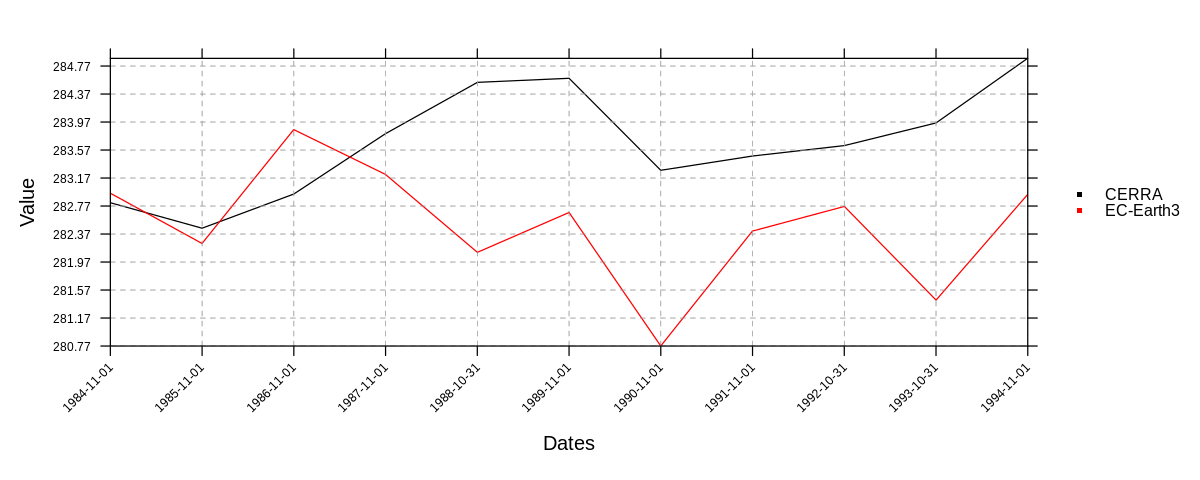

In [26]:
temporalPlot("CERRA" = o.paris.1984.1995 %>% aggregateGrid(aggr.y = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.1984.1995 %>% aggregateGrid(aggr.y = list(FUN = "mean")))

Quantile-quantile plot:

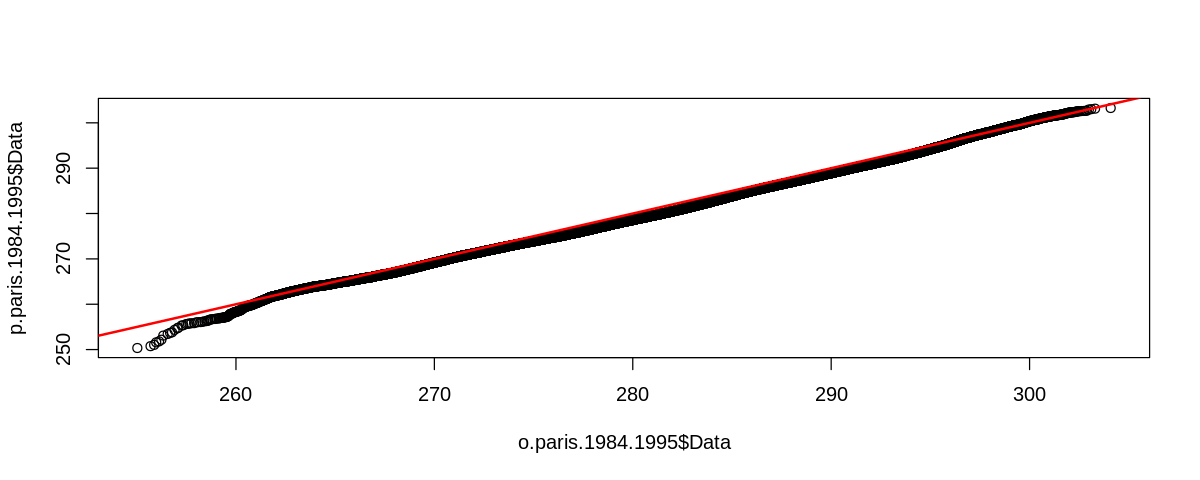

In [27]:
qqplot(o.paris.1984.1995$Data, p.paris.1984.1995$Data)
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

## 2. Bias correction

#### The `biasCorrection` function uses the nearest prediction grid-point for each observational grid-point for correcting the bias.

#### The scaling method:

In [28]:
cal.scaling <- biasCorrection(y = o.paris.1984.1995, 
                              x = p.paris.1984.1995, 
                              newdata = p.paris.1984.1995, 
                              method = "scaling", 
                              scaling.type = "additive")

[2024-04-30 08:29:11] Trying to determine the time zone...

[2024-04-30 08:29:11] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:29:12] Trying to determine the time zone...

[2024-04-30 08:29:12] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:29:12] Trying to determine the time zone...

[2024-04-30 08:29:12] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:29:13] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-04-30 08:29:15] Number of windows considered: 1...

[2024-04-30 08:29:15] Bias-correcting 1 members separately...

[2024-04-30 08:29:17] Done.



In [29]:
cal.scaling$Dates <- lapply(cal.scaling$Dates, as.character)

#### Results comparison for the climatological maps

[2024-04-30 08:29:17] - Computing climatology...

[2024-04-30 08:29:17] - Done.

[2024-04-30 08:29:17] - Computing climatology...

[2024-04-30 08:29:17] - Done.



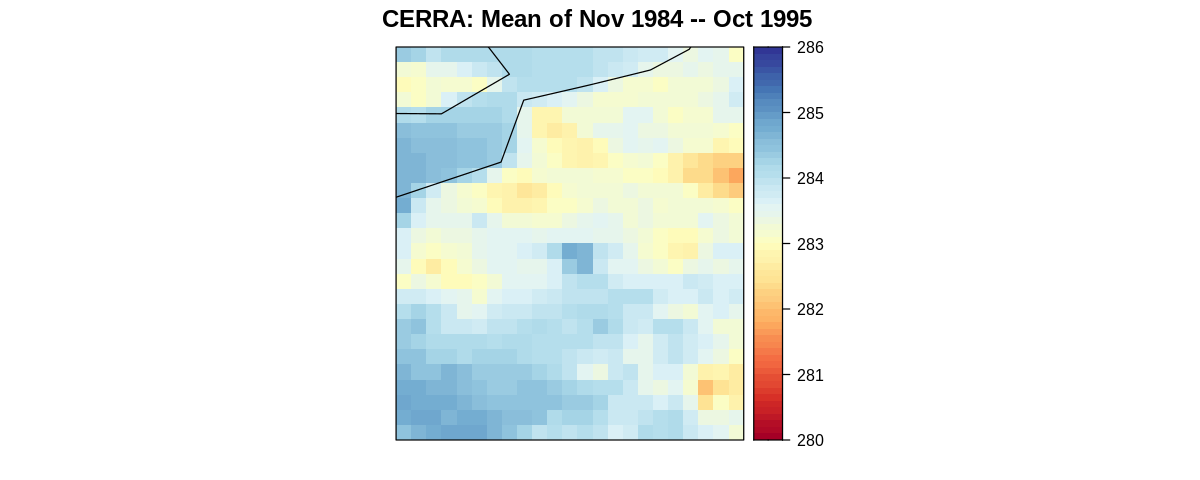

[2024-04-30 08:29:17] - Computing climatology...

[2024-04-30 08:29:17] - Done.



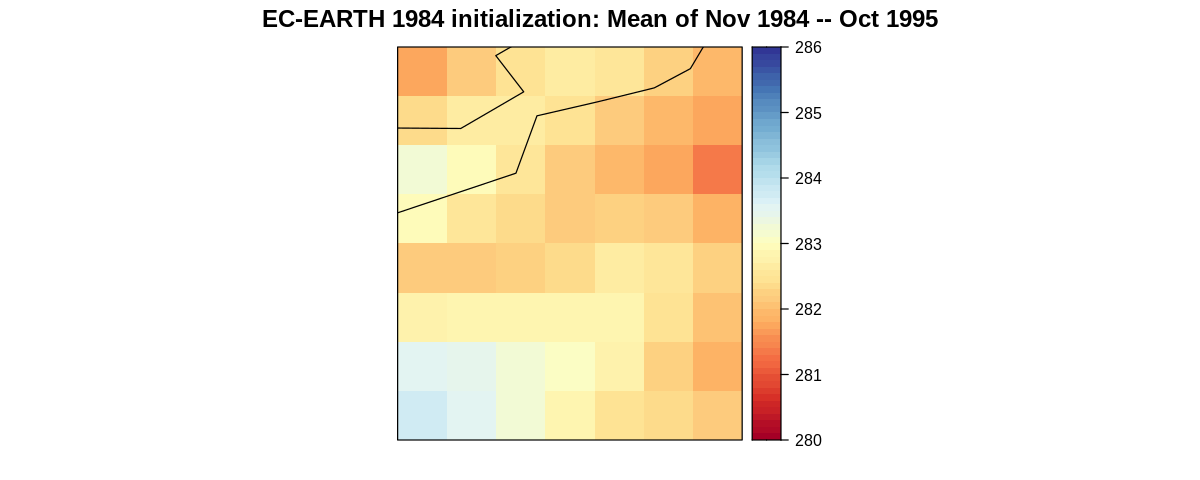

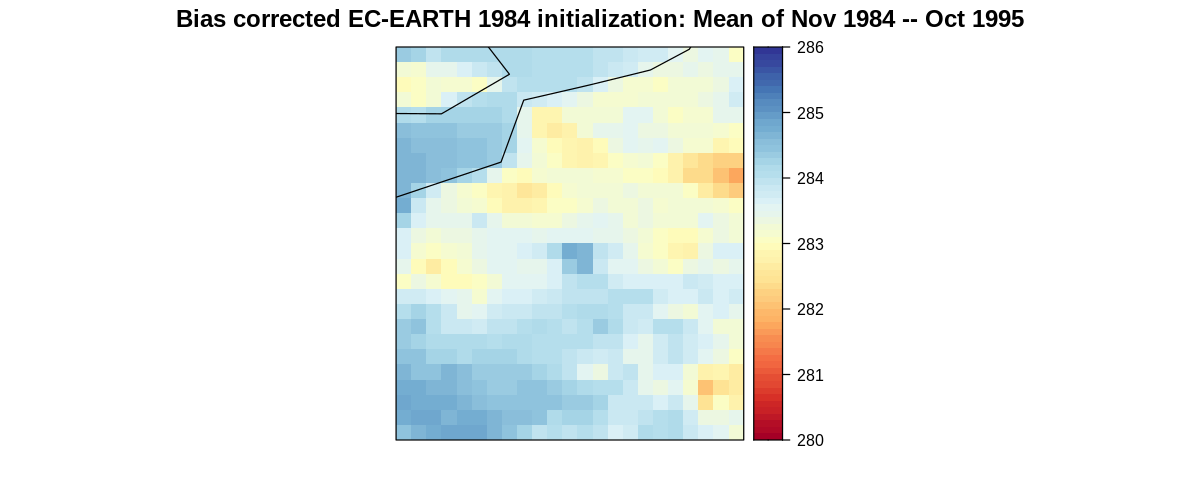

In [30]:
spatialPlot(climatology(o.paris.1984.1995), backdrop.theme = "coastline", at = seq(280, 286, 0.1), 
            main = "CERRA: Mean of Nov 1984 -- Oct 1995 ")
spatialPlot(climatology(p.paris.1984.1995), backdrop.theme = "coastline", at = seq(280, 286, 0.1), 
            main = "EC-EARTH 1984 initialization: Mean of Nov 1984 -- Oct 1995")
spatialPlot(climatology(cal.scaling), backdrop.theme = "coastline", at = seq(280, 286, 0.1), 
            main = "Bias corrected EC-EARTH 1984 initialization: Mean of Nov 1984 -- Oct 1995")


#### Results comparison for the spatial mean:

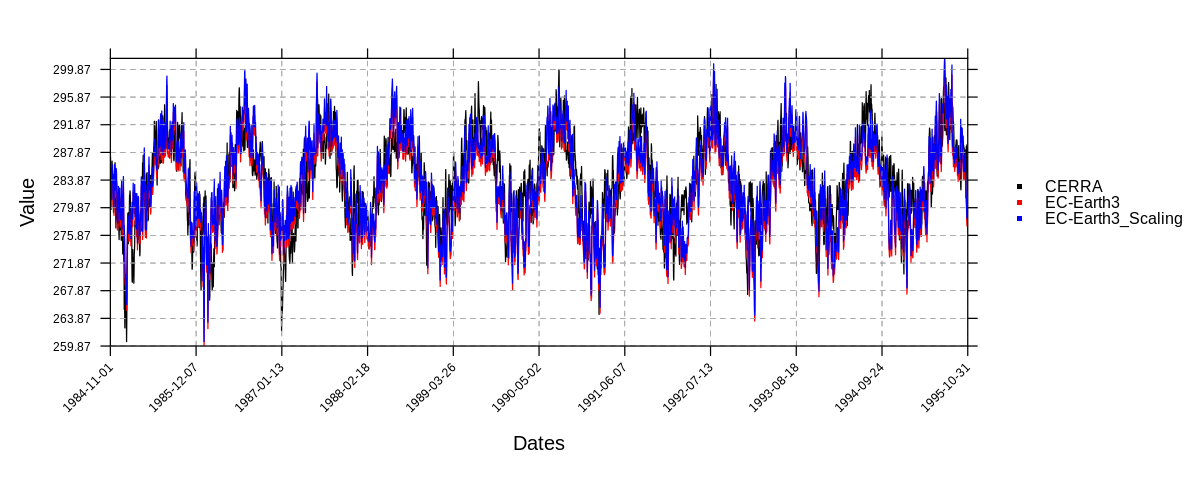

In [31]:
temporalPlot("CERRA" = o.paris.1984.1995, 
             "EC-Earth3" = p.paris.1984.1995,
             "EC-Earth3_Scaling" = cal.scaling) %>% suppressMessages

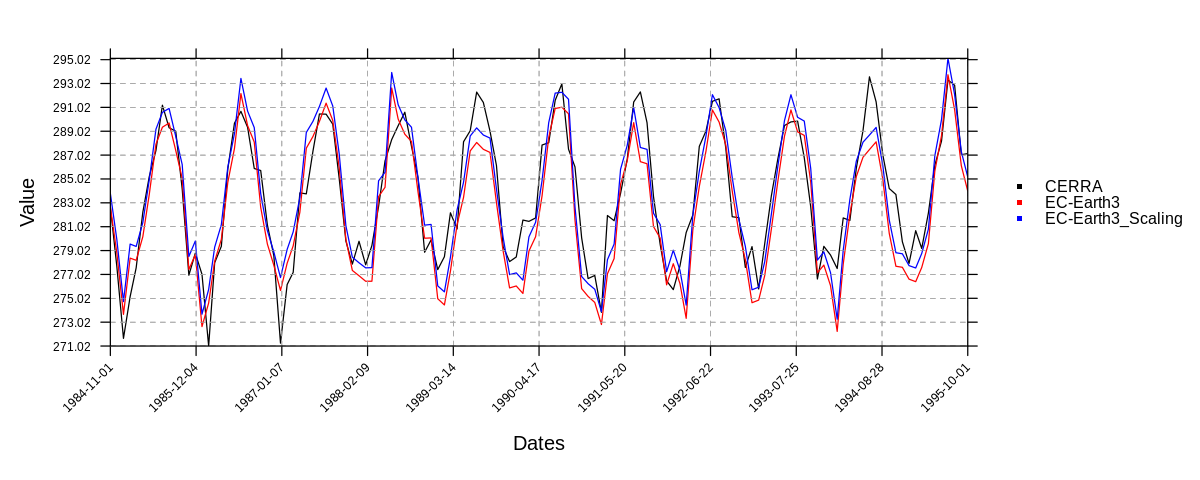

In [32]:
temporalPlot("CERRA" = o.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")),
             "EC-Earth3_Scaling" = cal.scaling %>% aggregateGrid(aggr.m = list(FUN = "mean"))) %>% suppressMessages

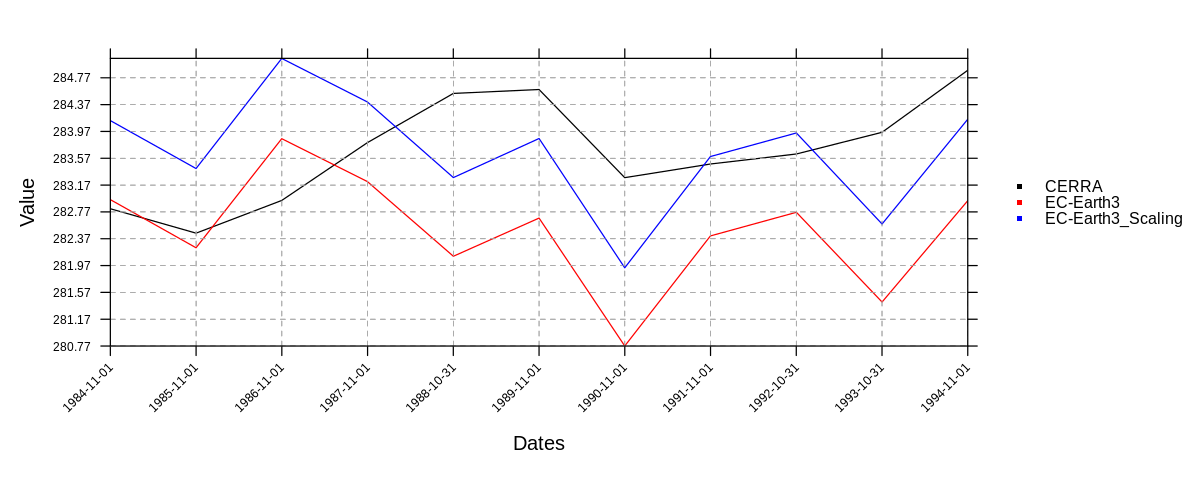

In [33]:
temporalPlot("CERRA" = o.paris.1984.1995 %>% aggregateGrid(aggr.y = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.1984.1995 %>% aggregateGrid(aggr.y = list(FUN = "mean")),
             "EC-Earth3_Scaling" = cal.scaling %>% aggregateGrid(aggr.y = list(FUN = "mean"))) %>% suppressMessages

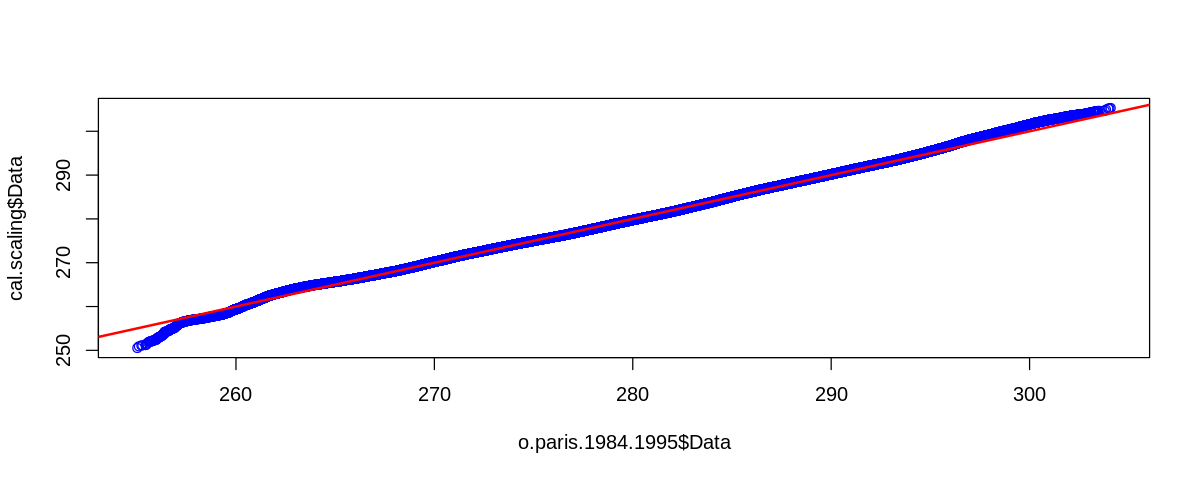

In [34]:
qqplot(o.paris.1984.1995$Data, cal.scaling$Data, col = "blue")
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

#### Results comparison for the point representing Paris:

In [35]:
x <- paris.centre@coords[1,"x"]
y <- paris.centre@coords[1,"y"]

In [36]:
o.paris.centre.monthly <- o.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")) %>% subsetGrid(lonLim = x, latLim = y)
p.paris.centre.monthly <- p.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")) %>% subsetGrid(lonLim = x, latLim = y)
c.paris.centre.monthly <- cal.scaling %>% aggregateGrid(aggr.m = list(FUN = "mean")) %>% subsetGrid(lonLim = x, latLim = y)


[2024-04-30 08:30:08] Performing monthly aggregation...

[2024-04-30 08:30:08] Done.

[2024-04-30 08:30:08] Performing monthly aggregation...

[2024-04-30 08:30:08] Done.

[2024-04-30 08:30:08] Performing monthly aggregation...

[2024-04-30 08:30:09] Done.



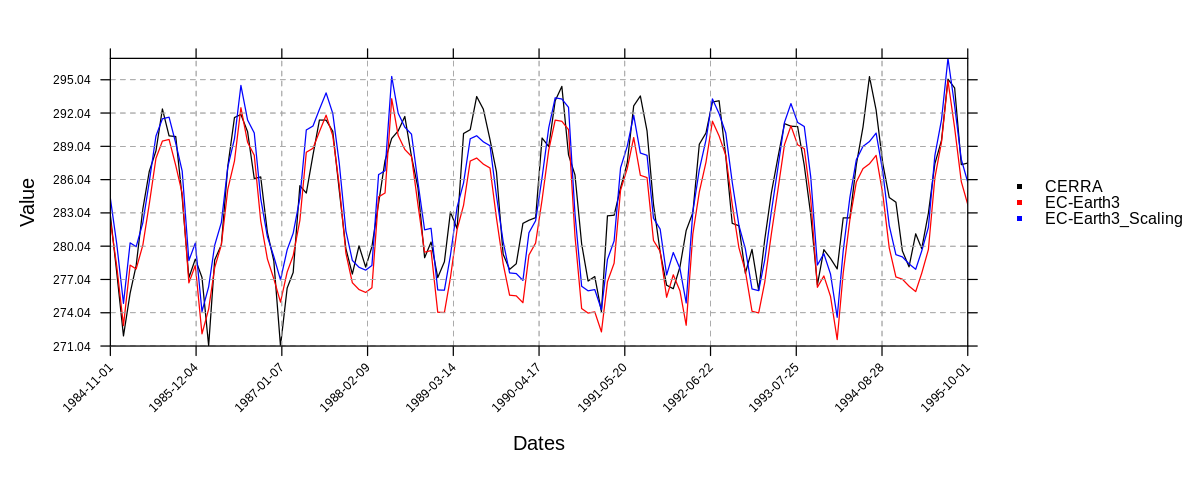

In [37]:
temporalPlot("CERRA" = o.paris.centre.monthly, 
             "EC-Earth3" = p.paris.centre.monthly,
             "EC-Earth3_Scaling" = c.paris.centre.monthly) %>% suppressMessages

In [38]:
o.paris.centre.yearly <- o.paris.1984.1995 %>% aggregateGrid(aggr.y = list(FUN = "mean")) %>% subsetGrid(lonLim = x, latLim = y)
p.paris.centre.yearly <- p.paris.1984.1995 %>% aggregateGrid(aggr.y = list(FUN = "mean")) %>% subsetGrid(lonLim = x, latLim = y)
c.paris.centre.yearly <- cal.scaling %>% aggregateGrid(aggr.y = list(FUN = "mean")) %>% subsetGrid(lonLim = x, latLim = y)

[2024-04-30 08:30:09] Performing annual aggregation...

[2024-04-30 08:30:09] Done.

[2024-04-30 08:30:09] Performing annual aggregation...

[2024-04-30 08:30:09] Done.

[2024-04-30 08:30:09] Performing annual aggregation...

[2024-04-30 08:30:09] Done.



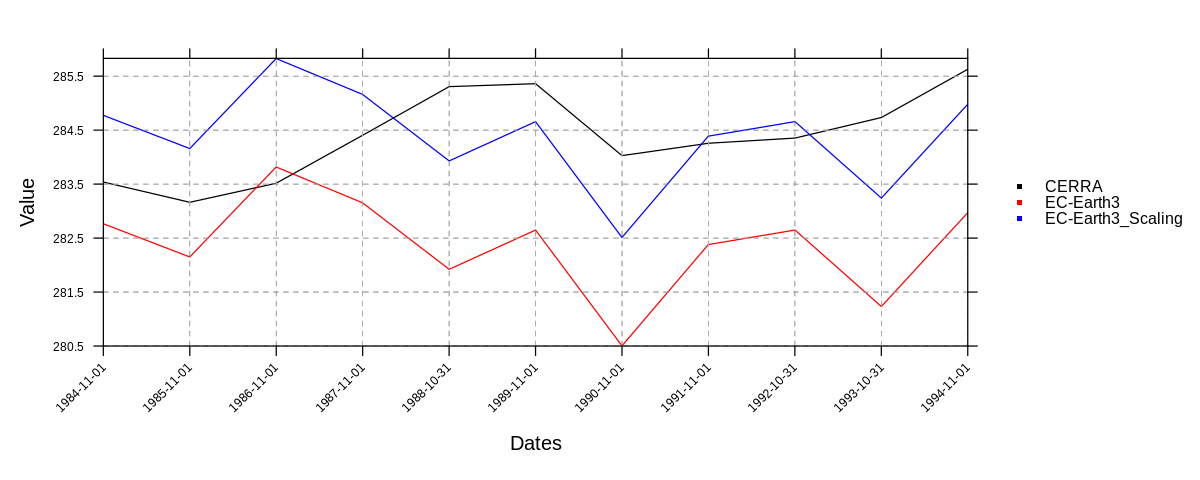

In [39]:
temporalPlot("CERRA" = o.paris.centre.yearly, 
             "EC-Earth3" = p.paris.centre.yearly,
             "EC-Earth3_Scaling" = c.paris.centre.yearly) %>% suppressMessages

#### The Empirical Quantile Mapping method:

In [40]:
cal.eqm <- biasCorrection(y = o.paris.1984.1995, x = p.paris.1984.1995, newdata = p.paris.1984.1995, method = "eqm")

[2024-04-30 08:30:10] Trying to determine the time zone...

[2024-04-30 08:30:10] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:30:10] Trying to determine the time zone...

[2024-04-30 08:30:10] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:30:10] Trying to determine the time zone...

[2024-04-30 08:30:10] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:30:11] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-04-30 08:30:12] Number of windows considered: 1...

[2024-04-30 08:30:12] Bias-correcting 1 members separately...

[2024-04-30 08:30:20] Done.



In [41]:
cal.eqm$Dates <- lapply(cal.eqm$Dates, as.character)

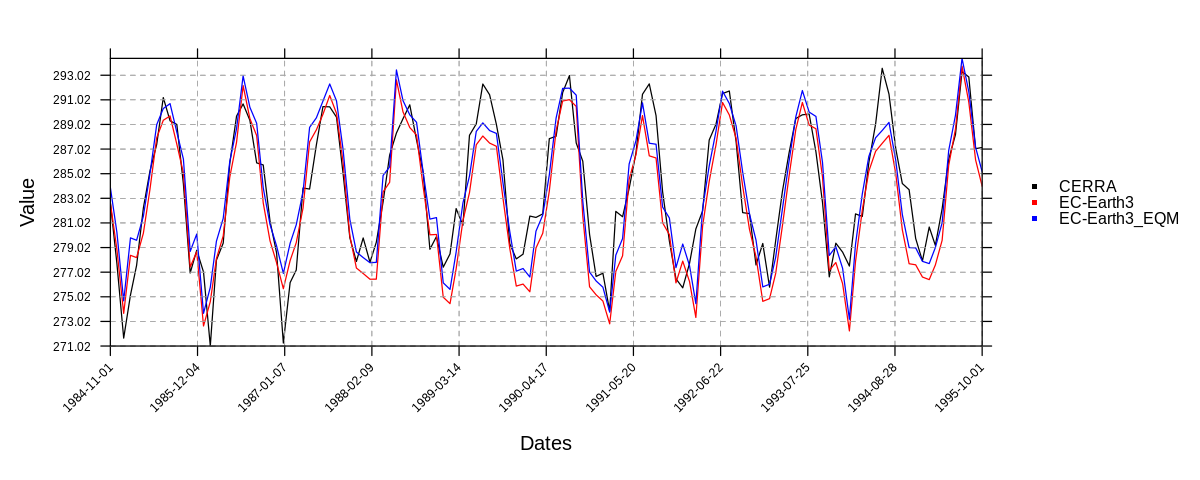

In [42]:
temporalPlot("CERRA" = o.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")),
             "EC-Earth3_EQM" = cal.eqm %>% aggregateGrid(aggr.m = list(FUN = "mean"))) %>% suppressMessages

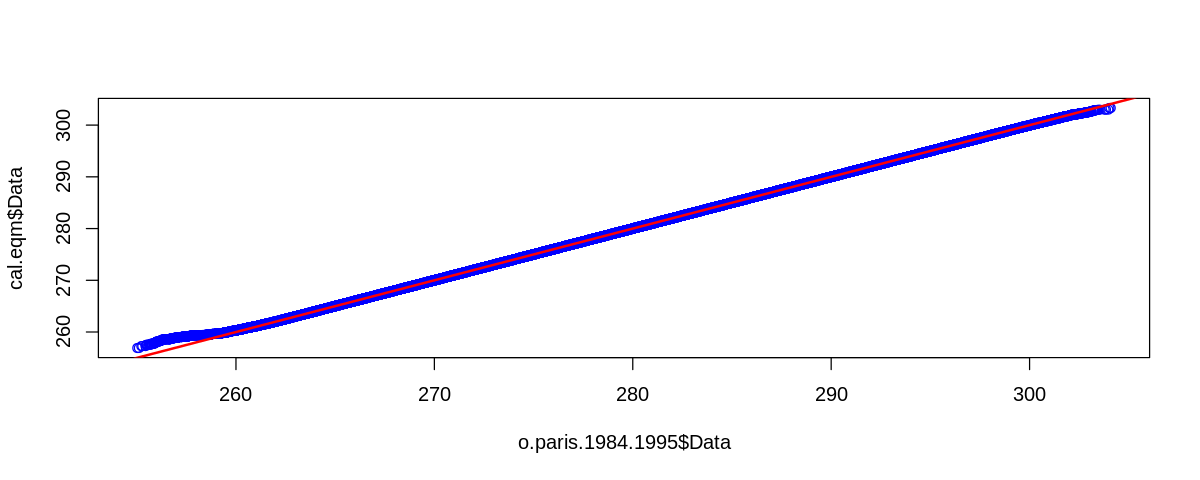

In [43]:
qqplot(o.paris.1984.1995$Data, cal.eqm$Data, col = "blue")
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

#### The Parametric Quantile Mapping method:

In [44]:
cal.pqm <- biasCorrection(y = o.paris.1984.1995, x = p.paris.1984.1995, newdata = p.paris.1984.1995,  
                      method = "pqm", fitdistr.args = list(densfun = "normal"))

[2024-04-30 08:31:08] Trying to determine the time zone...

[2024-04-30 08:31:08] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:31:08] Trying to determine the time zone...

[2024-04-30 08:31:08] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:31:08] Trying to determine the time zone...

[2024-04-30 08:31:08] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:31:09] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-04-30 08:31:10] Number of windows considered: 1...

[2024-04-30 08:31:10] Bias-correcting 1 members separately...

[2024-04-30 08:31:12] Done.



In [45]:
cal.pqm$Dates <- lapply(cal.pqm$Dates, as.character)

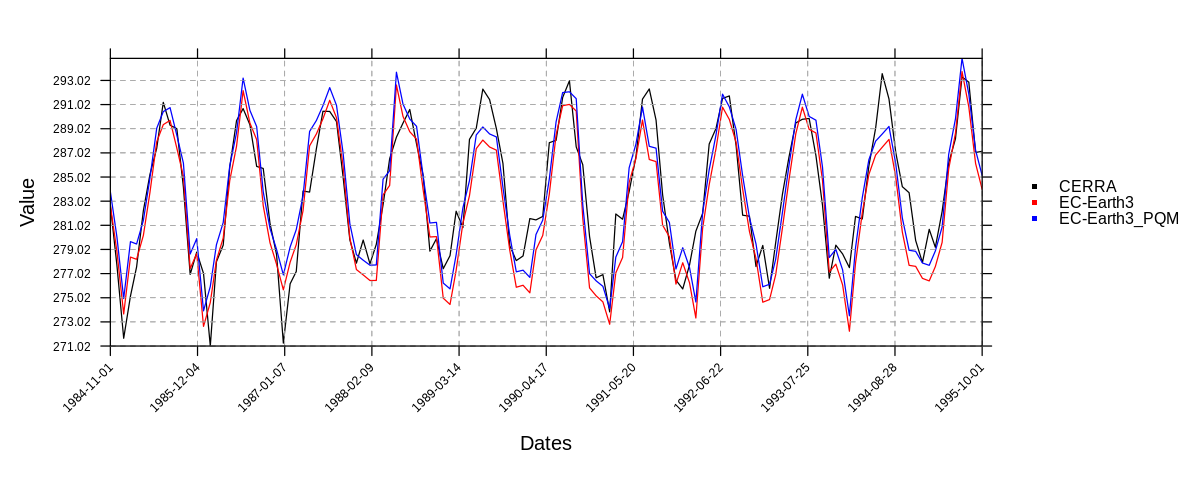

In [46]:
temporalPlot("CERRA" = o.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.1984.1995 %>% aggregateGrid(aggr.m = list(FUN = "mean")),
             "EC-Earth3_PQM" = cal.pqm %>% aggregateGrid(aggr.m = list(FUN = "mean"))) %>% suppressMessages

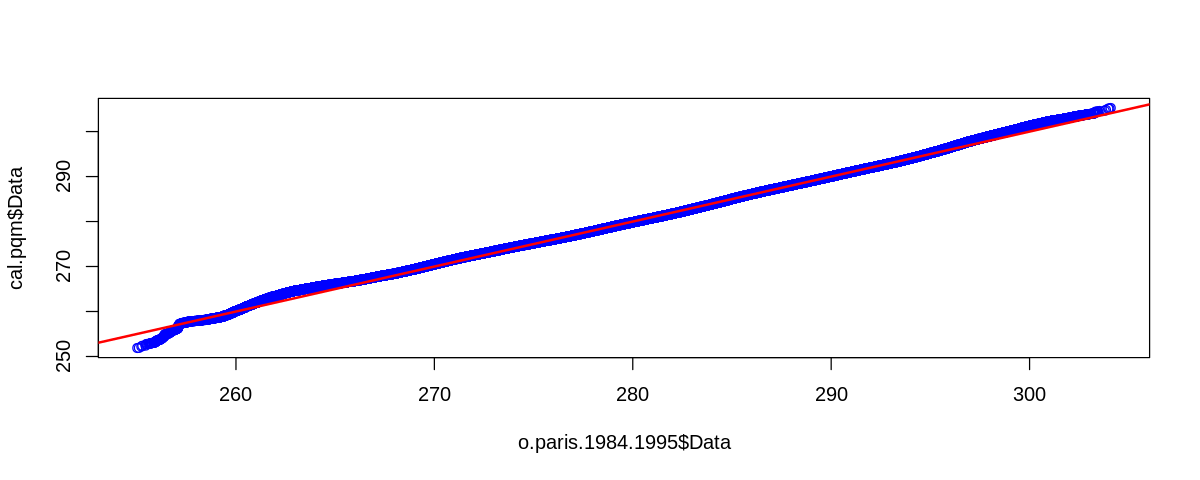

In [47]:
qqplot(o.paris.1984.1995$Data, cal.pqm$Data, col = "blue")
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

## 3. Bias correction in cross-validation mode

#### k-fold cross validation leaving one year out in each iterarion

In [48]:
cal.eqm.cv <- biasCorrection(y = o.paris.1984.1995, x = p.paris.1984.1995,
                            method = "eqm",
                            cross.val = "kfold",
                            folds = as.list(1985:1994)) %>% suppressMessages

In [49]:
cal.eqm.cv$Dates <- lapply(cal.eqm.cv$Dates, as.character)

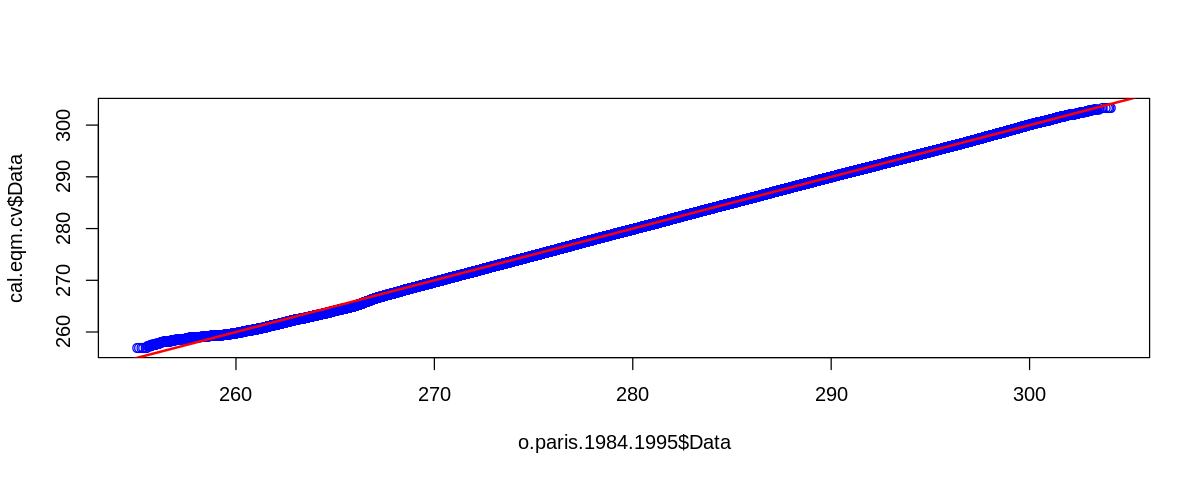

In [50]:
qqplot(o.paris.1984.1995$Data, cal.eqm.cv$Data, col = "blue")
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

## 4. Bias correction of each lead-year 
### 4.1. Data loading of decadal predictions


In this case we need to load data from each of the datasets we have previously created (excluding data before 1984).

In [51]:
datasets <- datasets[(datasets %>% grep(pattern = "1984")) : length(datasets)] %<>% print

 [1] "../data/ncml/EC-Earth3/dcppA-hindcast//s1984-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [2] "../data/ncml/EC-Earth3/dcppA-hindcast//s1985-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [3] "../data/ncml/EC-Earth3/dcppA-hindcast//s1986-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [4] "../data/ncml/EC-Earth3/dcppA-hindcast//s1987-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [5] "../data/ncml/EC-Earth3/dcppA-hindcast//s1988-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [6] "../data/ncml/EC-Earth3/dcppA-hindcast//s1989-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [7] "../data/ncml/EC-Earth3/dcppA-hindcast//s1990-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [8] "../data/ncml/EC-Earth3/dcppA-hindcast//s1991-r1i4p1f1_day_tas_gr_v20220322.ncml"
 [9] "../data/ncml/EC-Earth3/dcppA-hindcast//s1992-r1i4p1f1_day_tas_gr_v20220322.ncml"
[10] "../data/ncml/EC-Earth3/dcppA-hindcast//s1993-r1i4p1f1_day_tas_gr_v20220322.ncml"
[11] "../data/ncml/EC-Earth3/dcppA-hindcast//s1994-r1i4p1f1_day_tas_gr_v20220322.ncml"
[12] "../data/ncml/EC-Earth3/dcppA-hindcast

#### Create the lead-year x (in this example x = 1) series:

In [52]:
p.paris.ly1.l <- lapply(datasets, function(d) {
    di <- dataInventory(d) 
    y <- di$tas$Dimensions$time$Date_range %>%  substring(first = 1, last = 4) %>% as.numeric 
    g1 <- loadGridData(d, 
                 years = y, 
                 var = "tas",  
                 latLim = c(46.5, 51.5),
                 lonLim = c(0, 4.5)) 
    g2 <- loadGridData(d, 
                 years = y + 1, 
                 season = 1:10,
                 var = "tas",  
                 latLim = c(46.5, 51.5),
                 lonLim = c(0, 4.5)) 
    bindGrid(g1, g2, dimension = "time") 
}) %>% suppressMessages

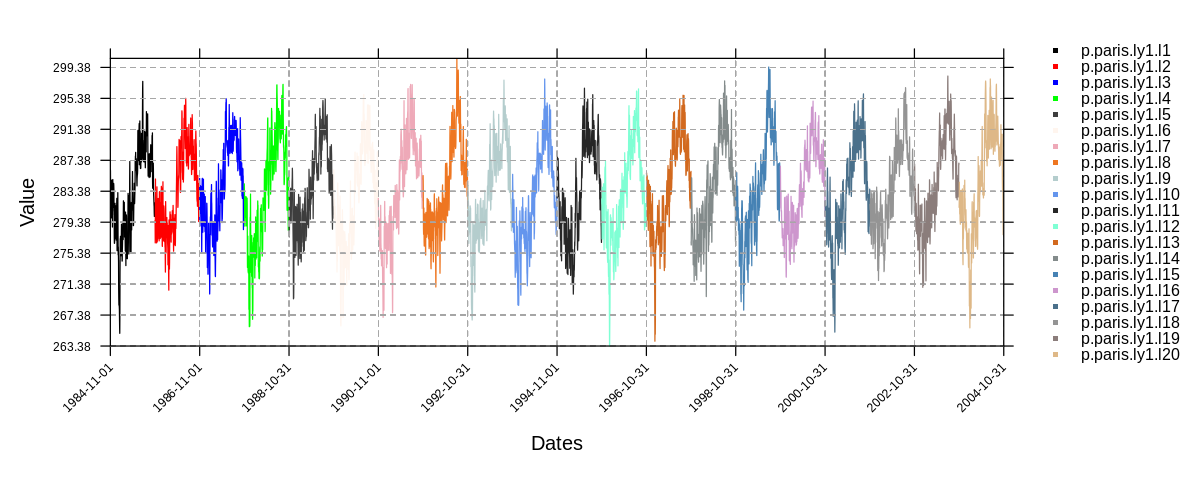

In [53]:
temporalPlot(p.paris.ly1.l) %>% suppressMessages

In [54]:
p.paris.ly1 <- do.call("bindGrid", c(p.paris.ly1.l, dimension = "time"))

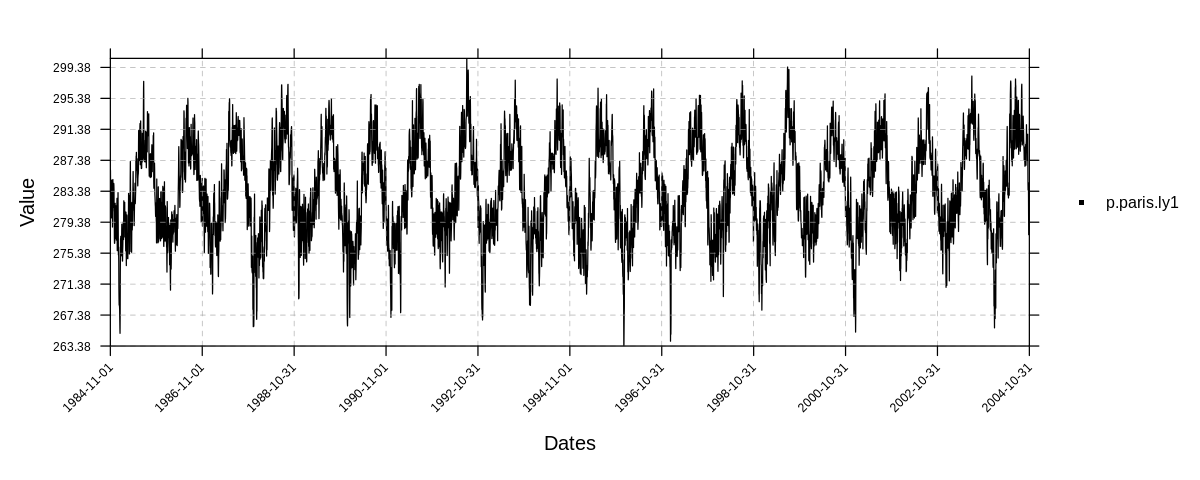

In [55]:
temporalPlot(p.paris.ly1) %>% suppressMessages

### 4.2. Data loading of the observational reference

We will reuse previously loaded data, and complete the series until 2004-10


In [56]:
o.paris.1995.2003.u <- lapply(1995:2003, function(x) {
    loadGridData(dataset.obs, 
                 var = "tas", 
                 latLim = c(46.5, 51.5),
                 lonLim = c(0, 4.5), 
                 years = x) %>% 
    upscaleGrid(times = 4, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
    redim(drop = TRUE) %>%
    suppressMessages
}) 

o.paris.2004.u <- loadGridData(dataset.obs, 
                        var = "tas", 
                        latLim = c(46.5, 51.5),
                        lonLim = c(0, 4.5), 
                        years = 2004,
                        season = 1:10) %>% 
    upscaleGrid(times = 4, aggr.fun = list(FUN = "mean", na.rm = T)) %>%
    redim(drop = TRUE) %>%
    suppressMessages

In [57]:
o.paris.1995.2003.u.b <- do.call("bindGrid", c(o.paris.1995.2003.u, dimension = "time"))

In [58]:
o.paris.1984.2004 <- bindGrid(o.paris.1984.u, o.paris.1985.1994.u.b, o.paris.1995.2003.u.b, o.paris.2004.u, dimension = "time")

In [ ]:
o.paris.1995.2003.u.b <- o.paris.1995.2003.u <- o.paris.1984.u <- o.paris.1985.1994.u.b <- o.paris.2004.u <- NULL

### 4.3. Visualization of the biases (observation vs prediction)

Decadal bias:

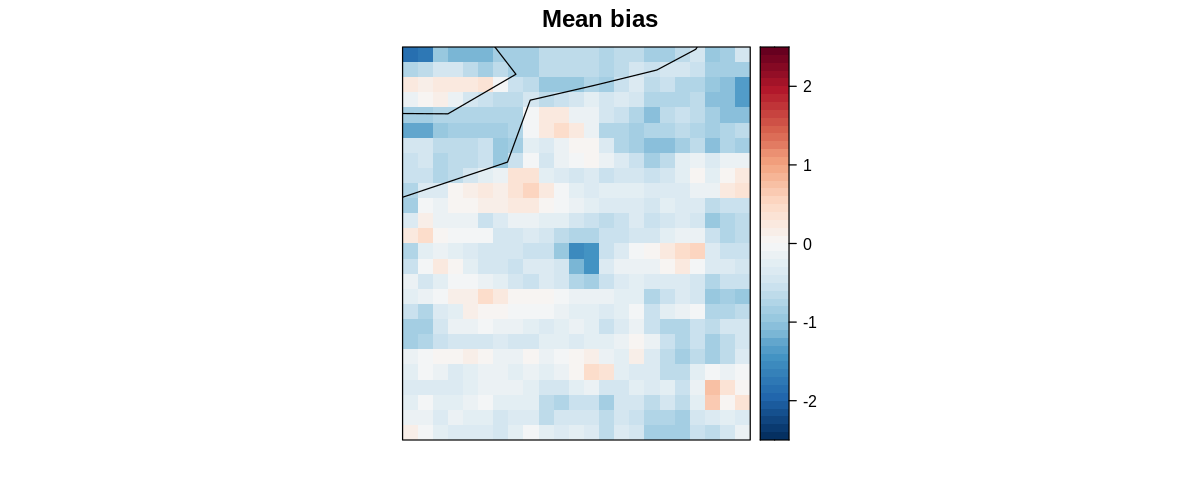

In [59]:
p.paris.ly1.i <- interpGrid(p.paris.ly1, new.coordinates = getGrid(o.paris.1984.2004)) %>% suppressMessages
diff <- gridArithmetics(p.paris.ly1.i %>% climatology, 
                        o.paris.1984.2004 %>% climatology, 
                        operator = "-") %>% suppressMessages
spatialPlot(diff, backdrop.theme = "coastline", at = seq(-2.5, 2.5, 0.1), 
            color.theme = "RdBu",
            rev.colors = TRUE,
            main = "Mean bias")

In [ ]:
p.paris.ly1.i <- NULL

Daily series:

pad applied on the interval: day

pad applied on the interval: day



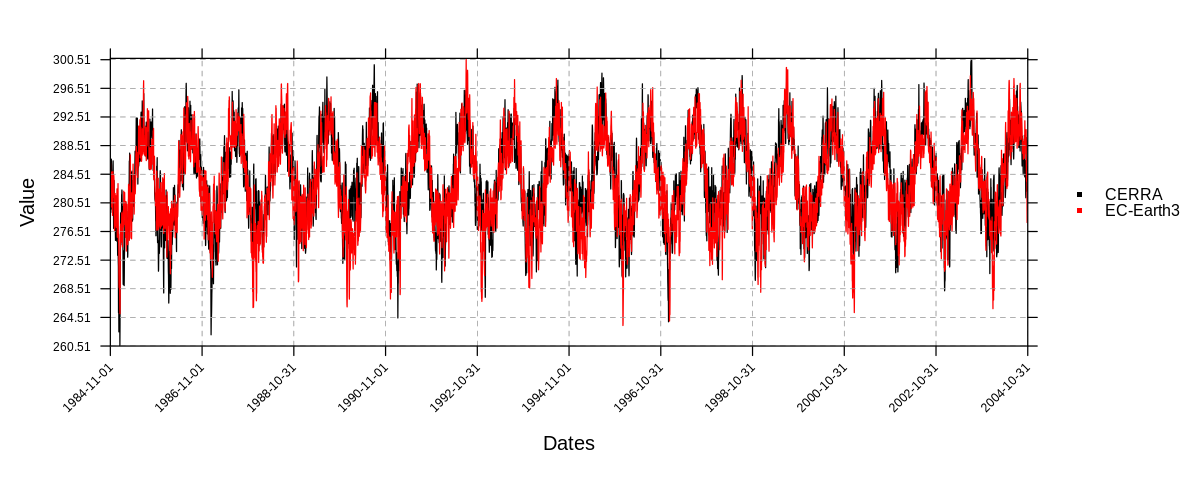

In [60]:
temporalPlot("CERRA" = o.paris.1984.2004, "EC-Earth3" = p.paris.ly1)

Monthly mean series:

[2024-04-30 08:41:32] Performing monthly aggregation...

[2024-04-30 08:41:33] Done.

[2024-04-30 08:41:33] Performing monthly aggregation...

[2024-04-30 08:41:33] Done.

pad applied on the interval: month

pad applied on the interval: month



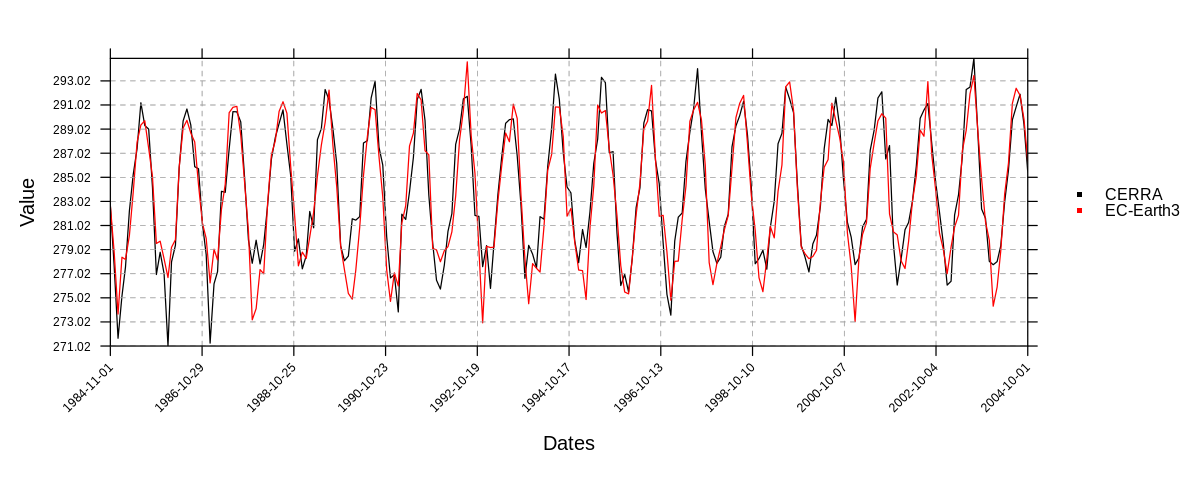

In [61]:
temporalPlot("CERRA" = o.paris.1984.2004 %>% aggregateGrid(aggr.m = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.ly1 %>% aggregateGrid(aggr.m = list(FUN = "mean")))

Annual mean series:

[2024-04-30 08:41:33] Performing annual aggregation...

[2024-04-30 08:41:34] Done.

[2024-04-30 08:41:34] Performing annual aggregation...

[2024-04-30 08:41:34] Done.

pad applied on the interval: year

pad applied on the interval: year



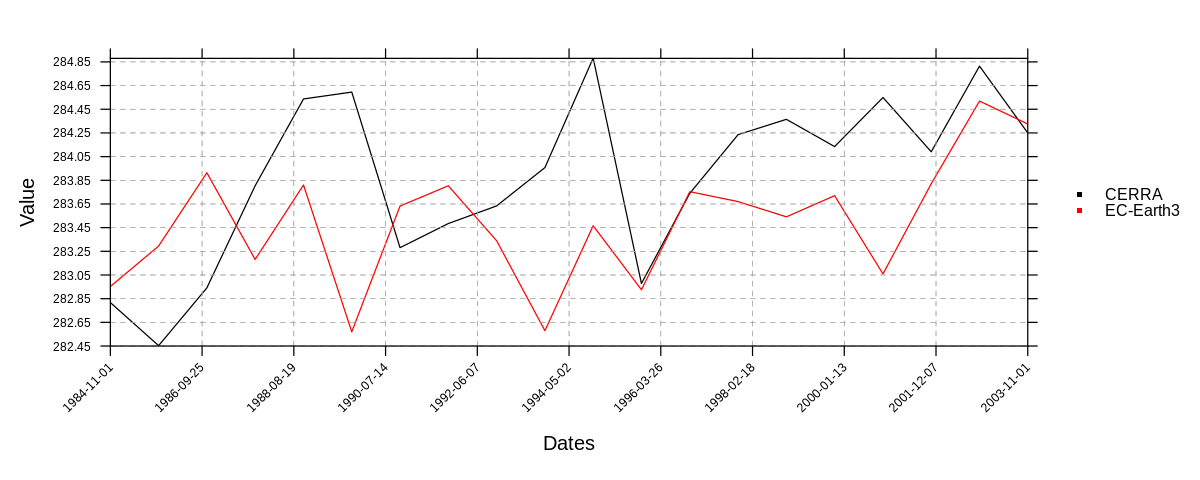

In [62]:
temporalPlot("CERRA" = o.paris.1984.2004 %>% aggregateGrid(aggr.y = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.ly1 %>% aggregateGrid(aggr.y = list(FUN = "mean")))

Quantile-quantile plot:

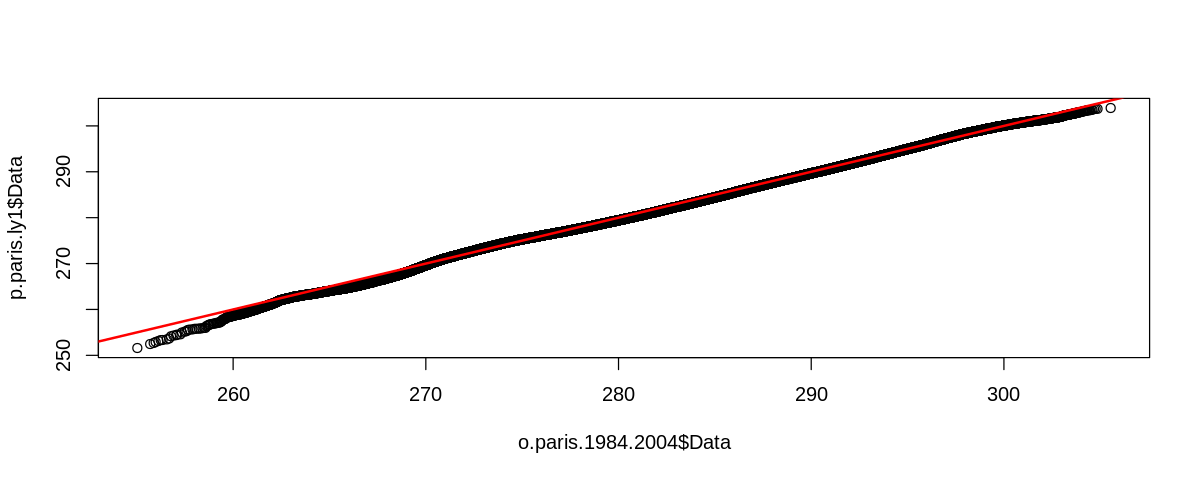

In [63]:
qqplot(o.paris.1984.2004$Data, p.paris.ly1$Data)
lines(c(200, 400), c(200, 400), col = "red", lwd = 2)

### 4.4. Bias correction and visualization of the results



In [64]:
cal.eqm.ly1 <- biasCorrection(y = o.paris.1984.2004, x = p.paris.ly1, newdata = p.paris.ly1, method = "eqm")

[2024-04-30 08:41:44] Trying to determine the time zone...

[2024-04-30 08:41:44] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:41:45] Trying to determine the time zone...

[2024-04-30 08:41:45] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:41:45] Trying to determine the time zone...

[2024-04-30 08:41:45] Time zone identified and set to GMT
See 'setGridDates.asPOSIXlt' to change the time zone

[2024-04-30 08:41:46] Argument precipitation is set as FALSE, please ensure that this matches your data.

[2024-04-30 08:41:48] Number of windows considered: 1...

[2024-04-30 08:41:49] Bias-correcting 1 members separately...

[2024-04-30 08:42:08] Done.



In [65]:
cal.eqm.ly1$Dates <- lapply(cal.eqm.ly1$Dates, as.character)

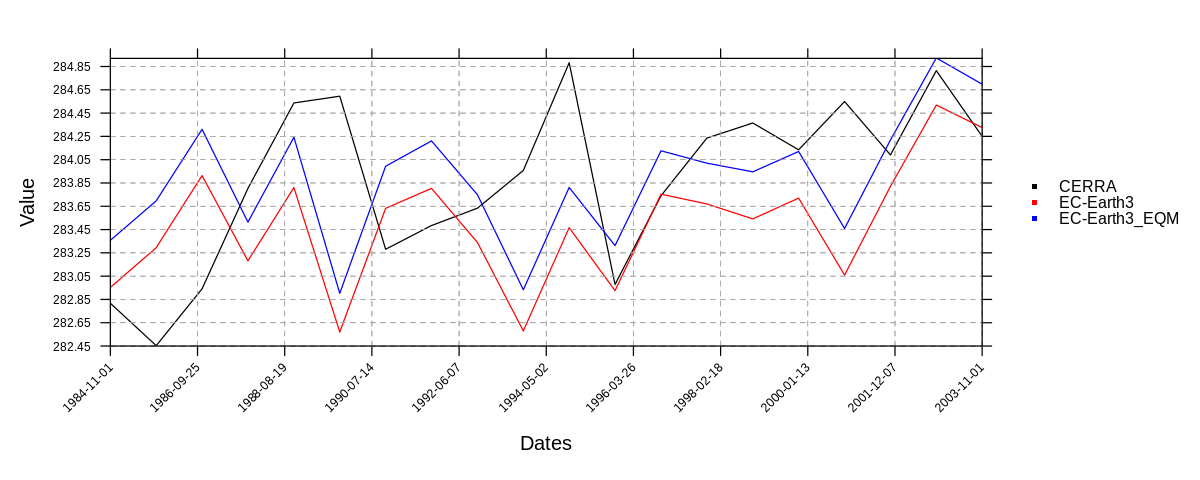

In [66]:
temporalPlot("CERRA" = o.paris.1984.2004 %>% aggregateGrid(aggr.y = list(FUN = "mean")), 
             "EC-Earth3" = p.paris.ly1 %>% aggregateGrid(aggr.y = list(FUN = "mean")),
             "EC-Earth3_EQM" = cal.eqm.ly1 %>% aggregateGrid(aggr.y = list(FUN = "mean"))) %>% suppressMessages